In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import operator
from bisect import bisect
%matplotlib inline

In [44]:
class TSP(object):
    def __init__(self,start=1,dissipation=.2,alpha=1.0,beta=1.0):
        #inputs
        self.dissipation=dissipation
        self.alpha=alpha
        self.beta=beta
        self.start=start
        self.step=0
        
        #setup
        self.history_k={}
        self.history_s={}
        self.tsp=self.init_tsp()

        self.state=self.init_graph(self.tsp)
        self.history_s[self.step]=self.state
        self.k,self.last_visited=self.init_k(self.state)
        self.last_solution={}
        
        
    
    def init_tsp(self):
        tsp=nx.Graph()
        tsp.add_edge(1,2,dist=1)
        tsp.add_edge(1,3,dist=1)
        tsp.add_edge(1,4,dist=2)
        tsp.add_edge(2,3,dist=3)
        tsp.add_edge(2,4,dist=4)
        tsp.add_edge(3,4,dist=2)
        
        return tsp
        
    def init_graph(self,tsp):
        g=tsp.copy()
        for u,v in g.edges():
            g[u][v]['p']=0.5
            g[u][v]['dist']=0.0

        #print g.edges(data=True)

        return g

    def init_k(self,g):
        k=nx.DiGraph()
        last_visited={}
        
        for u,v,d in g.edges(data=True):
            last_visited[(u,v)]={}
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            last_visited[(u,v)]['p']=n_label
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),dist=float(d['dist']),step=self.step)
            last_visited[(u,v)]['dist']=n_label
            
        self.history_k[self.step]=k.copy()
        self.step+=1

        return k,last_visited
    
    def walk(self):
        #initialize
        g=self.state.copy()
        tsp=self.tsp.copy()
        tabu=[int(self.start)]
        
        #print (set(g.nodes())<=set(tabu))

        while (set(g.nodes())<=set(tabu))==False: #iterate until all nodes included
        #for i in xrange(g.number_of_nodes()-1): #for tabu walk
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]

            for n in g.nodes(): #no tabu list
                if n != tabu[-1]:
                    n_l.append(n)
                    p_l.append(g[tabu[-1]][n]['p'])
                    if g[tabu[-1]][n]['dist']==0.0:
                        h_l.append(10.0)
                    else:
                        h_l.append(1.0/g[tabu[-1]][n]['dist'])

#            for n in g.nodes(): #tabu list
#               if n not in tabu:
#                   n_l.append(n)
#                   p_l.append(g[tabu[-1]][n]['p'])
#                   if g[tabu[-1]][n]['dist']==0.0:
#                       h_l.append(10.0)
#                   else:
#                       h_l.append(1.0/g[tabu[-1]][n]['dist'])
            c_l=np.power(p_l,self.alpha)*np.power(h_l,self.beta)
            n_index=self.make_decision(c_l)
            new_n=n_l[n_index]
            tabu.append(new_n)

        score=0.0
        e_r=[tuple(tabu[i:i+2]) for i in xrange(0,len(tabu), 1)]
        del e_r[-1]

        for e in e_r:
            score+=float(tsp[e[0]][e[1]]['dist'])
        
        #print 'route', tabu
        #print 'score', score

        return tuple(tabu), score

    def update_edges(self,route,score):
        g_t=self.state.copy()
        g=self.state.copy()
        p=float(self.dissipation)
        tsp=self.tsp.copy()
        
        #print 'before', g_t.edges(data=True)
        #print 'reduction', p
        
        #update k with route
        n_label=self.k.number_of_nodes()+1
        self.k.add_node(n_label,label=route,step=self.step)
        self.last_solution['route']=n_label
        
        # k edges from tsp edge info to route
        for e in self.last_visited:
            self.k.add_edge(self.last_visited[e]['p'],n_label,step=self.step)
            self.k.add_edge(self.last_visited[e]['dist'],n_label,step=self.step)
            
        
        e_r=[tuple(route[i:i+2]) for i in xrange(0,len(route), 1)]
        del e_r[-1]
        t_update=1.0/score
        for u,v,d in g_t.edges(data=True):
            #update pheromone
            g_t[u][v]['p']=float(g[u][v]['p'])*(1.0-p)
            
            #update k for pheromone reduction
            last_n=self.last_visited[(u,v)]['p']
            n_label=self.k.number_of_nodes()+1
            self.k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.k.add_edge(last_n,n_label,step=self.step)
            self.last_visited[(u,v)]['p']=n_label
        
        #add k for score
        n_label=self.k.number_of_nodes()+1
        self.k.add_node(n_label,label=score,step=self.step)
        self.k.add_edge(self.last_solution['route'],n_label,step=self.step)
        self.last_solution['score']=n_label
        
        e_list=[]
        
        for e in e_r:
            
            #check ordering
            if (e[0],e[1]) not in self.last_visited.keys():
                e=(e[1],e[0])
            
            #update dist
            if g_t[e[0]][e[1]]['dist']==0.0:
                g_t[e[0]][e[1]]['dist']=float(tsp[e[0]][e[1]]['dist'])
                
                #update k for changed distance
                n_label=self.k.number_of_nodes()+1
                last_n=self.last_visited[(e[0],e[1])]['dist']
                self.k.add_node(n_label,label=(e[0],e[1]),p=float(d['dist']),step=self.step)
                self.k.add_edge(last_n,n_label,step=self.step)
                self.k.add_edge(self.last_solution['route'],n_label,step=self.step)
                
                #update k for route score
                self.k.add_edge(n_label,self.last_solution['score'],step=self.step)
                self.last_visited[(e[0],e[1])]['dist']=n_label
            else:
                #update k for route score
                last_n=self.last_visited[(e[0],e[1])]['dist']
                self.k.add_edge(last_n,self.last_solution['score'],step=self.step)
                
                
            if e not in e_list:
                g_t[e[0]][e[1]]['p']=float(g_t[e[0]][e[1]]['p'])+t_update*p

                #update k for pheromone addition
                last_n=self.last_visited[(e[0],e[1])]['p']
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label=(e[0],e[1]),p=float(g_t[e[0]][e[1]]['p']),step=self.step)
                self.k.add_edge(last_n,n_label,step=self.step)
                self.k.add_edge(self.last_solution['route'],n_label,step=self.step)
                self.k.add_edge(self.last_solution['score'],n_label,step=self.step)
                self.last_visited[(e[0],e[1])]['p']=n_label
            
            #append to examined edges
            e_list.append(e)
        
        self.history_k[self.step]=self.k.copy()
        self.history_s[self.step]=g_t.copy()
        self.step+=1
        #print 'after', g_t.edges(data=True)    
        return g_t



    def make_decision(self,ph_l):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        if sum(ph_l)==0.0:
            percent_list=[1.0/len(ph_l)]*len(ph_l)
        else:
            percent_list = [float(i)/sum(ph_l) for i in ph_l]   
        cumulative_percent=np.cumsum(percent_list)
        #print cumulative_percent

        #Choose decision index
        select_index=bisect(cumulative_percent,np.random.uniform(0,1,1))

        return select_index




    def k_step(k,t_new,t_old,route,last_visited,changed_d):
        #get step number

        #route
        n_label=k.number_of_nodes()+1
        k.add_node(n_label,r=tuple(route),step=step)

        #changed distance
        for e in changed_d:
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,)

        for e,d in last_visited.iteritems():
            print 'hi'




[(1, 2, {'p': 0.2107779999893804, 'dist': 1.0}), (1, 3, {'p': 0.2107779999893804, 'dist': 1.0}), (1, 4, {'p': 2.4103449119297053e-91, 'dist': 2.0}), (2, 3, {'p': 9.881734971430792e-98, 'dist': 3.0}), (2, 4, {'p': 2.8304756729108255e-95, 'dist': 4.0}), (3, 4, {'p': 0.2107779999893804, 'dist': 2.0})]


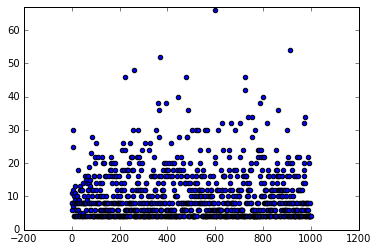

In [46]:
t=TSP(start=4)

routes=[]
for i in xrange(1000):
    r,s=t.walk()
    routes.append((r,s))
    t.state=t.update_edges(r,s)
    #print t.edges(data=True)
                  
#print routes
print t.state.edges(data=True)

s=[i[1] for i in routes]
gen=xrange(len(s))
plt.scatter(gen,s)
_=plt.ylim([0.0,max(s)+1.0])

(array([ 305.,    2.,  135.,    1.,  156.,    4.,   64.,    2.,   76.,
           3.,   37.,    2.,   61.,    0.,   39.,    1.,   26.,    0.,
          22.,    1.,   13.,    1.,    6.,    0.,    6.,    0.,   13.,
           0.,    5.,    0.,    3.,    0.,    3.,    0.,    3.,    0.,
           2.,    0.,    1.,    0.,    0.,    0.,    3.,    0.,    1.,
           0.,    0.,    0.,    1.,    0.,    1.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 <a list of 61 Patch objects>)

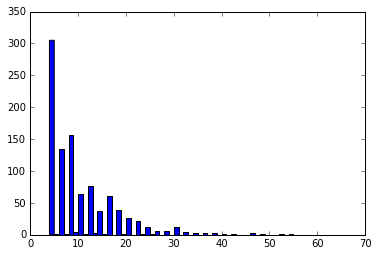

In [50]:
plt.hist(s,bins=xrange(int(min(s)),int(max(s)),1))

In [23]:
l_1=[1,2,3]
l_2=[1,2,9]
print not set(l_1) <= set(l_2)
print l_1

True
[1, 2, 3]


In [39]:
print t.k.nodes(data=True)

[(1, {'p': 0.5, 'step': 0, 'label': (1, 2)}), (2, {'step': 0, 'dist': 0.0, 'label': (1, 2)}), (3, {'p': 0.5, 'step': 0, 'label': (1, 3)}), (4, {'step': 0, 'dist': 0.0, 'label': (1, 3)}), (5, {'p': 0.5, 'step': 0, 'label': (1, 4)}), (6, {'step': 0, 'dist': 0.0, 'label': (1, 4)}), (7, {'p': 0.5, 'step': 0, 'label': (2, 3)}), (8, {'step': 0, 'dist': 0.0, 'label': (2, 3)}), (9, {'p': 0.5, 'step': 0, 'label': (2, 4)}), (10, {'step': 0, 'dist': 0.0, 'label': (2, 4)}), (11, {'p': 0.5, 'step': 0, 'label': (3, 4)}), (12, {'step': 0, 'dist': 0.0, 'label': (3, 4)}), (13, {'step': 1, 'label': (4, 3, 2, 3, 1)}), (14, {'p': 0.4, 'step': 1, 'label': (1, 2)}), (15, {'p': 0.4, 'step': 1, 'label': (1, 3)}), (16, {'p': 0.4, 'step': 1, 'label': (1, 4)}), (17, {'p': 0.4, 'step': 1, 'label': (2, 3)}), (18, {'p': 0.4, 'step': 1, 'label': (2, 4)}), (19, {'p': 0.4, 'step': 1, 'label': (3, 4)}), (20, {'step': 1, 'label': 9.0}), (21, {'p': 2.0, 'step': 1, 'label': (3, 4)}), (22, {'p': 0.4222222222222222, 'step':